# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#your code here
df_train = pd.read_csv('./data/dataset_2_train.csv')
df_test = pd.read_csv('./data/dataset_2_test.csv')
display(df_train.head())
display(df_train.shape)
display(df_test.shape)

def convert_district(df, from_val, to_val):
    df.loc[df['district'] == from_val, 'district'] = to_val

convert_district(df_train, 61, 54)
convert_district(df_train, 60, 0)
convert_district(df_test, 61, 54)
convert_district(df_test, 60, 0)

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


(967, 5)

(967, 5)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


training contraceptive use mean 0.389866
test contraceptive use mean 0.395036


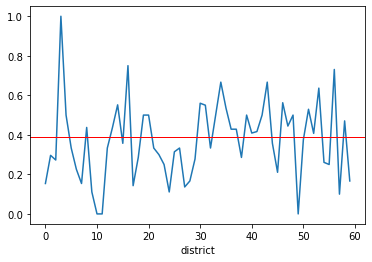

In [4]:
print(sorted(df_train.district.unique()))
print(sorted(df_test.district.unique()))
display(df_train.groupby(['district'])['contraceptive_use'].mean().plot())
plt.axhline(linewidth=1, color='r', y = df_train.contraceptive_use.mean())
print("training contraceptive use mean %f" % df_train.contraceptive_use.mean())
print("test contraceptive use mean %f" % df_test.contraceptive_use.mean())

##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [118]:
from scipy.special import expit

np.random.seed(109)

X = df_train.copy()

mu_beta_0 = 2
sigma_beta_0 = 1
X['beta_0'] = np.random.normal(mu_beta_0, sigma_beta_0, df_train.shape[0])

beta_1 = 4
beta_2 = -3
beta_3 = -2

X['contraceptive_use_hat'] = expit(X['beta_0'] +  
                                   beta_1 * X['urban'] + 
                                   beta_2 * X['living.children'] + 
                                   beta_3 * X['age_mean'])

print("simulated contraceptive use avg is %f" % X['contraceptive_use_hat'].mean() )

simulated contraceptive use avg is 0.477367


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

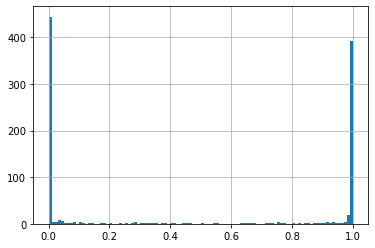

In [102]:
X['contraceptive_use_hat'].hist(bins=100)

In [112]:
np.random.seed(44)
districts_count = len(X['district'].unique())

with pm.Model() as model_a3:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    beta_0s = pm.Normal('beta_0s', mu=mu_0, tau=tau_0, shape=districts_count)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=100)

    p_logit = pm.Deterministic('p_logit', beta_0s[X['district']] +
                                                     beta_1 * X['urban']    +
                                                     beta_2 * X['living.children'] +
                                                     beta_3 * X['age_mean'] ) 
    obs = pm.Bernoulli('observed', logit_p=p_logit, observed=X['contraceptive_use_hat'])
    trace = pm.sample(2000, tune=20000, target_accept=0.999, cores=4)

/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0s, tau_0, mu_0]
INFO:pymc3:NUTS: [beta_3, beta_2, beta_1, beta_0s, tau_0, mu_0]
Sampling 4 chains, 0 divergences:   3%|▎         | 3017/88000 [01:26<40:31, 34.95draws/s]  


ValueError: Not enough samples to build a trace.

In [111]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-84.985,63.388,-184.212,1.701,28.068,21.108,5.0,5.0,5.0,22.0,2.06
beta_0s[0],-84.357,69.250,-196.518,17.027,26.744,19.800,7.0,7.0,7.0,48.0,1.65
beta_0s[1],-90.534,77.731,-233.282,14.590,32.773,24.494,6.0,6.0,6.0,32.0,1.92
beta_0s[2],-88.583,74.270,-220.188,13.213,30.700,22.892,6.0,6.0,6.0,24.0,1.86
beta_0s[3],-87.604,73.463,-216.370,11.192,30.080,22.407,6.0,6.0,6.0,26.0,1.81
...,...,...,...,...,...,...,...,...,...,...,...
p_logit[962],-304.258,142.319,-558.267,-55.785,22.071,15.718,42.0,42.0,45.0,165.0,1.06
p_logit[963],-301.096,135.829,-551.802,-70.159,14.263,10.118,91.0,91.0,94.0,751.0,1.04
p_logit[964],-525.897,266.599,-1010.646,-63.862,21.676,17.217,151.0,120.0,205.0,794.0,1.03
p_logit[965],-425.325,202.808,-800.910,-77.907,23.330,17.646,76.0,67.0,101.0,994.0,1.04


Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/Users/xiaosong/miniconda3/envs/cs109b/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/xiaosong/miniconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/xiaosong/miniconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/xiaoso

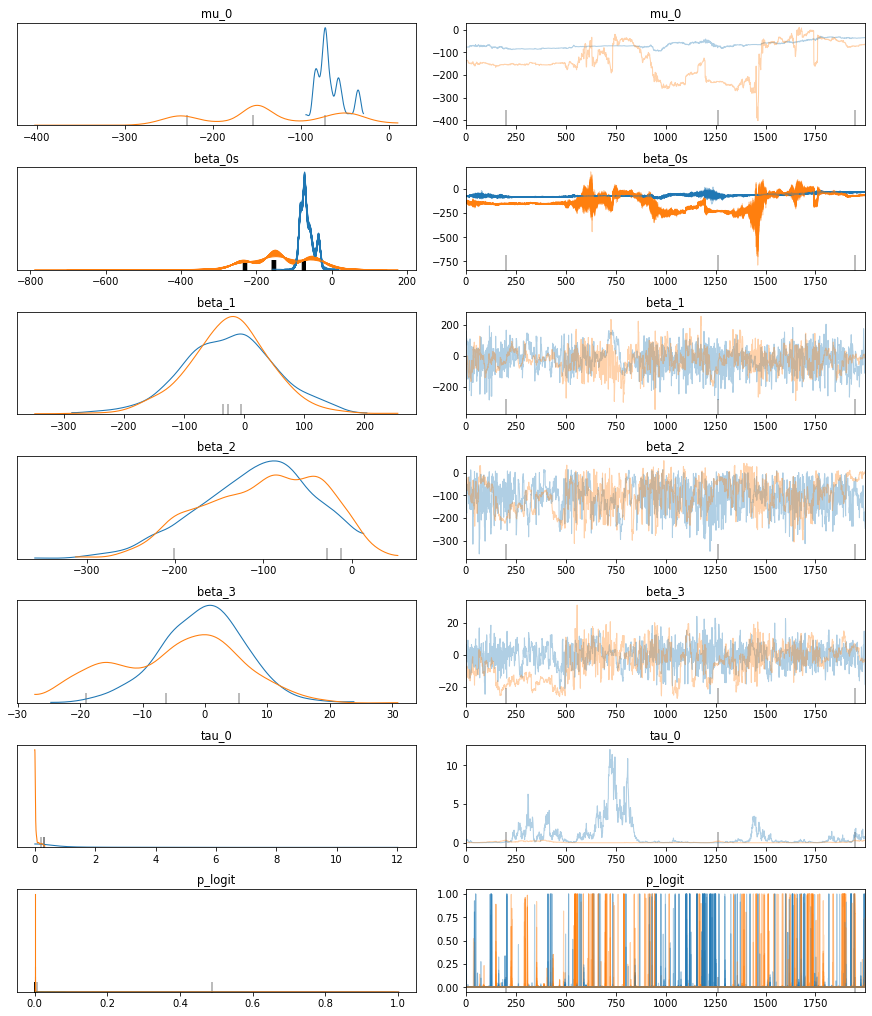

In [17]:
#your code here
pm.traceplot(trace);

your response here

### based on the `r_hat` values, which are relatively close to 1, it appears that samplers have converged

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

In [8]:
#your code here
pm.summary(trace)

KeyboardInterrupt: 

your response here


##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [7]:
#your code here

np.random.seed(44)
X = df_train.copy()
districts_count = len(X['district'].unique())

with pm.Model() as model_a3:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    beta_0s = pm.Normal('beta_0s', mu=mu_0, tau=tau_0, shape=districts_count)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=100)

    p_logit = pm.Deterministic('p_logit', beta_0s[X['district']] +
                                                     beta_1 * X['urban']    +
                                                     beta_2 * X['living.children'] +
                                                     beta_3 * X['age_mean'] ) 
    obs = pm.Bernoulli('observed', logit_p=p_logit, observed=X['contraceptive_use'])
    trace = pm.sample(2000, tune=2000, target_accept=0.9, cores=4)

/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0s, tau_0, 

##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [39]:
#your code here
summary = pm.summary(trace)
display(summary)

/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.616,0.263,-2.121,-1.142,0.012,0.009,450.0,444.0,451.0,956.0,1.01
beta_0s[0],-2.096,0.503,-3.055,-1.177,0.014,0.010,1325.0,1325.0,1330.0,3330.0,1.00
beta_0s[1],-2.143,0.383,-2.865,-1.431,0.014,0.010,793.0,787.0,797.0,2016.0,1.00
beta_0s[2],-1.795,0.497,-2.691,-0.823,0.014,0.010,1323.0,1323.0,1325.0,3467.0,1.00
beta_0s[3],-1.509,0.588,-2.684,-0.452,0.014,0.010,1732.0,1713.0,1724.0,3028.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
p_logit[962],-1.099,0.403,-1.869,-0.350,0.004,0.003,10198.0,7581.0,10691.0,5270.0,1.00
p_logit[963],-1.297,0.388,-2.003,-0.545,0.004,0.003,8164.0,7069.0,8084.0,5526.0,1.00
p_logit[964],0.268,0.369,-0.412,0.965,0.006,0.005,3243.0,3243.0,3248.0,5113.0,1.00
p_logit[965],-1.086,0.420,-1.850,-0.279,0.004,0.003,9417.0,7609.0,9664.0,5720.0,1.00


/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/xiaosongxu/miniconda/envs/cs109b2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/

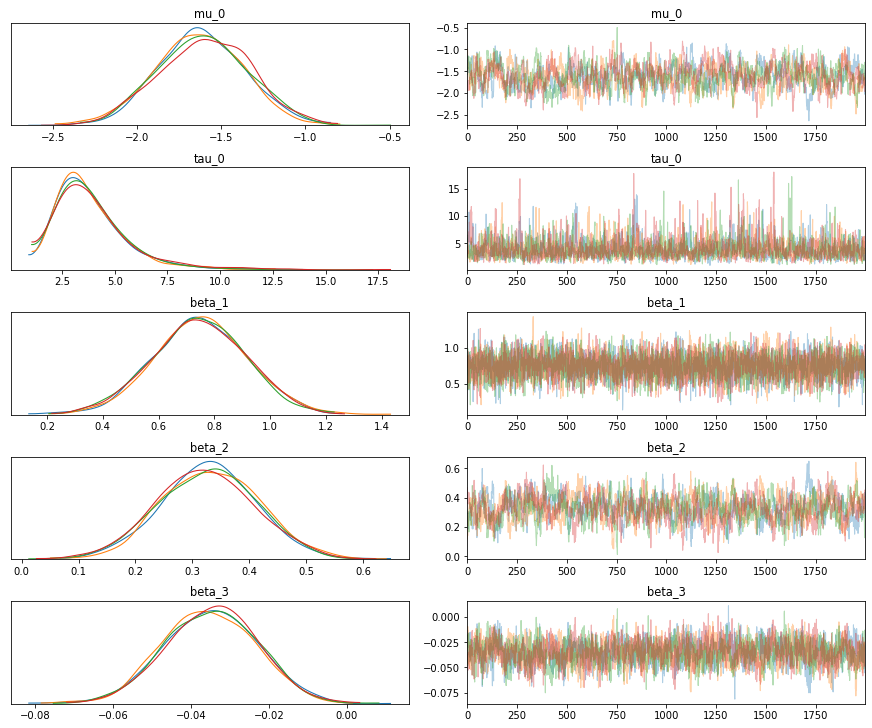

In [12]:
pm.traceplot(trace, var_names=['mu_0', 'tau_0', 'beta_1', 'beta_2', 'beta_3']);

your response here

## actual data converged
based on the following observations
1. `r_hat` are very close to 1, which indicates that it converged.
2. trace plot also shows a nice convergence of the variable distribution of various draws. 

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [58]:
#your code here
# a = beta_0s[0]
beta_0_mean_sorted = summary[summary.index.str.startswith('beta_0')]['mean'].sort_values()


beta_0s[11]   -2.216
beta_0s[28]   -2.162
beta_0s[1]    -2.143
beta_0s[10]   -2.119
beta_0s[27]   -2.110
beta_0s[0]    -2.096
beta_0s[9]    -2.076
beta_0s[57]   -2.075
beta_0s[17]   -2.061
beta_0s[7]    -2.015
beta_0s[6]    -1.985
beta_0s[45]   -1.982
beta_0s[24]   -1.968
beta_0s[54]   -1.930
beta_0s[59]   -1.863
beta_0s[55]   -1.818
beta_0s[25]   -1.813
beta_0s[18]   -1.807
beta_0s[21]   -1.801
beta_0s[2]    -1.795
beta_0s[38]   -1.794
beta_0s[29]   -1.787
beta_0s[49]   -1.783
beta_0s[15]   -1.754
beta_0s[22]   -1.692
beta_0s[23]   -1.681
beta_0s[12]   -1.679
beta_0s[32]   -1.673
beta_0s[52]   -1.626
beta_0s[40]   -1.621
beta_0s[5]    -1.606
beta_0s[26]   -1.603
beta_0s[50]   -1.600
beta_0s[41]   -1.560
beta_0s[44]   -1.558
beta_0s[36]   -1.546
beta_0s[33]   -1.539
beta_0s[13]   -1.527
beta_0s[3]    -1.509
beta_0s[37]   -1.499
beta_0s[42]   -1.476
beta_0s[58]   -1.452
beta_0s[4]    -1.452
beta_0s[47]   -1.407
beta_0s[8]    -1.391
beta_0s[20]   -1.386
beta_0s[19]   -1.364
beta_0s[51]  

your response here

### the highest base rate (intercept mean) is district 56 
### the lowest intercept mean is district 11 

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [9]:
#your code here


your response here

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [10]:
#your code here


your response here

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [11]:
#your code here


your response here